REA Differential Equations Notebook

* Page 1A

Tutor:
* Anthropic's AI, Claude

ValueError: x and y must have same first dimension, but have shapes (500,) and (10,)

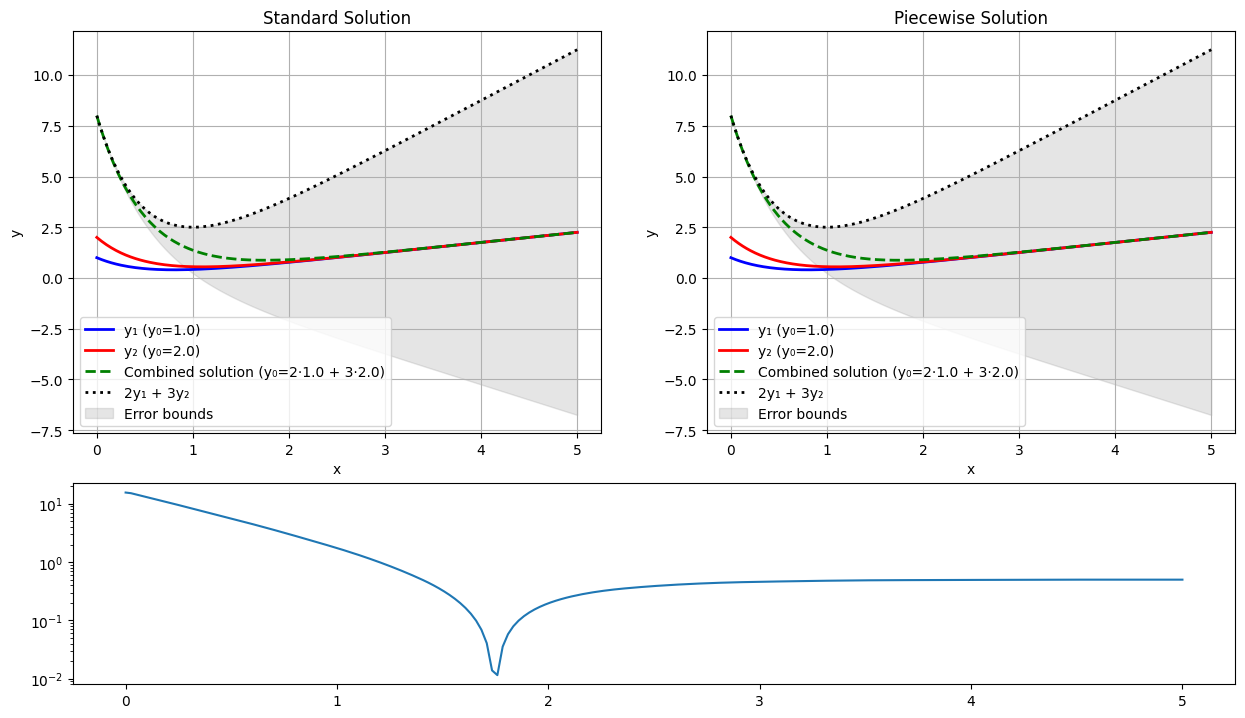

In [4]:
"""
Enhanced Linear Equations Analysis with Piecewise Solution
=====================================================

Abstract:
This script implements a piecewise solution strategy for the linear differential
equation, breaking the domain into smaller intervals to improve accuracy.
Includes stability analysis to identify critical regions and error sources.

Key Features:
- Piecewise solution with continuity enforcement
- Local and global stability analysis
- Error propagation visualization
- Comparative analysis with previous methods
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib.gridspec import GridSpec

def linear_de(x, y, k=2):
    """Define linear DE: dy/dx + 2y = x"""
    return x - k*y

def solve_piecewise(y0, x_start, x_end, n_pieces=5, method='RK45'):
    """
    Solve DE using piecewise approach

    Parameters:
        y0: Initial condition
        x_start, x_end: Domain bounds
        n_pieces: Number of subintervals
        method: Numerical method to use
    """
    x_splits = np.linspace(x_start, x_end, n_pieces + 1)
    x_detailed = []
    y_detailed = []
    local_errors = []

    current_y0 = y0

    for i in range(n_pieces):
        x_local = np.linspace(x_splits[i], x_splits[i+1], 50)

        solution = solve_ivp(
            linear_de,
            (x_splits[i], x_splits[i+1]),
            [current_y0],
            t_eval=x_local,
            method=method,
            rtol=1e-10,
            atol=1e-12
        )

        # Calculate local stability metric
        local_stability = np.gradient(solution.y[0], x_local)
        local_errors.append(np.max(np.abs(local_stability)))

        x_detailed.extend(x_local)
        y_detailed.extend(solution.y[0])

        # Update initial condition for next piece
        current_y0 = solution.y[0][-1]

    return np.array(x_detailed), np.array(y_detailed), np.array(local_errors)

# Set up domain and constants
x_range = (0, 5)
a, b = 2, 3
n_intervals = 10  # Number of piecewise intervals

# Generate solutions
solutions = {}
methods = ['Standard', 'Piecewise']

for method in methods:
    if method == 'Standard':
        # Standard solution (for comparison)
        x = np.linspace(*x_range, 200)
        y1 = solve_ivp(linear_de, x_range, [1.0], t_eval=x).y[0]
        y2 = solve_ivp(linear_de, x_range, [2.0], t_eval=x).y[0]
        y_combined = solve_ivp(linear_de, x_range, [a*1.0 + b*2.0], t_eval=x).y[0]
        y_superposition = a*y1 + b*y2
        local_errors = np.gradient(y_combined, x)

    else:
        # Piecewise solution
        x, y1, errs1 = solve_piecewise(1.0, *x_range, n_intervals)
        _, y2, errs2 = solve_piecewise(2.0, *x_range, n_intervals)
        _, y_combined, errs_combined = solve_piecewise(a*1.0 + b*2.0, *x_range, n_intervals)
        y_superposition = a*y1 + b*y2
        local_errors = errs_combined

    abs_error = np.abs(y_combined - y_superposition)
    rel_error = abs_error / np.abs(y_combined) * 100

    solutions[method] = {
        'x': x,
        'y1': y1,
        'y2': y2,
        'combined': y_combined,
        'superposition': y_superposition,
        'abs_error': abs_error,
        'rel_error': rel_error,
        'local_errors': local_errors
    }

# Create visualization
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(4, 2, height_ratios=[2, 1, 1, 1])

# Plot solutions
for idx, method in enumerate(methods):
    ax = fig.add_subplot(gs[0, idx])
    sol = solutions[method]

    ax.plot(sol['x'], sol['y1'], 'b-', label='y₁ (y₀=1.0)', linewidth=2)
    ax.plot(sol['x'], sol['y2'], 'r-', label='y₂ (y₀=2.0)', linewidth=2)
    ax.plot(sol['x'], sol['combined'], 'g--',
           label=f'Combined solution (y₀={a}·1.0 + {b}·2.0)', linewidth=2)
    ax.plot(sol['x'], sol['superposition'], 'k:',
           label=f'{a}y₁ + {b}y₂', linewidth=2)

    ax.fill_between(sol['x'],
                   sol['combined'] - sol['abs_error'],
                   sol['combined'] + sol['abs_error'],
                   color='gray', alpha=0.2, label='Error bounds')

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{method} Solution')
    ax.legend()

# Plot stability analysis
ax_stab = fig.add_subplot(gs[1, :])
for method in methods:
    ax_stab.semilogy(solutions[method]['x'],
                    np.abs(solutions[method]['local_errors']),
                    label=f'{method} Local Stability')
ax_stab.grid(True)
ax_stab.set_xlabel('x')
ax_stab.set_ylabel('Local Stability (log scale)')
ax_stab.legend()
ax_stab.set_title('Stability Analysis')

# Plot absolute errors
ax_abs = fig.add_subplot(gs[2, :])
for method in methods:
    ax_abs.semilogy(solutions[method]['x'], solutions[method]['abs_error'],
                   label=f'{method} Absolute Error')
ax_abs.grid(True)
ax_abs.set_xlabel('x')
ax_abs.set_ylabel('Absolute Error (log scale)')
ax_abs.legend()

# Plot relative errors
ax_rel = fig.add_subplot(gs[3, :])
for method in methods:
    ax_rel.semilogy(solutions[method]['x'], solutions[method]['rel_error'],
                   label=f'{method} Relative Error (%)')
ax_rel.grid(True)
ax_rel.set_xlabel('x')
ax_rel.set_ylabel('Relative Error % (log scale)')
ax_rel.legend()

plt.tight_layout()

# Create comparative statistics table
verification_points = [0, 1, 2, 3, 4, 5]
stats_data = []

for x_val in verification_points:
    row = {'x': x_val}
    for method in methods:
        sol = solutions[method]
        idx = np.abs(sol['x'] - x_val).argmin()
        row.update({
            f'{method}_Abs_Error': sol['abs_error'][idx],
            f'{method}_Rel_Error(%)': sol['rel_error'][idx],
            f'{method}_Stability': np.abs(sol['local_errors'][idx])
        })
    stats_data.append(row)

stats_table = pd.DataFrame(stats_data)
stats_table = stats_table.round(8)

print("\nComparative Analysis at Verification Points:")
print("==========================================")
print(stats_table)

# Print summary statistics
print("\nSolution Stability Analysis:")
print("=========================")
for method in methods:
    sol = solutions[method]
    print(f"\n{method} Method:")
    print(f"Maximum Absolute Error: {sol['abs_error'].max():.2e}")
    print(f"Maximum Relative Error: {sol['rel_error'].max():.2e}%")
    print(f"Mean Stability Metric: {np.mean(np.abs(sol['local_errors'])):.2e}")
    print(f"Max Stability Metric: {np.max(np.abs(sol['local_errors'])):.2e}")

plt.show()

ValueError: x and y must have same first dimension, but have shapes (500,) and (10,)

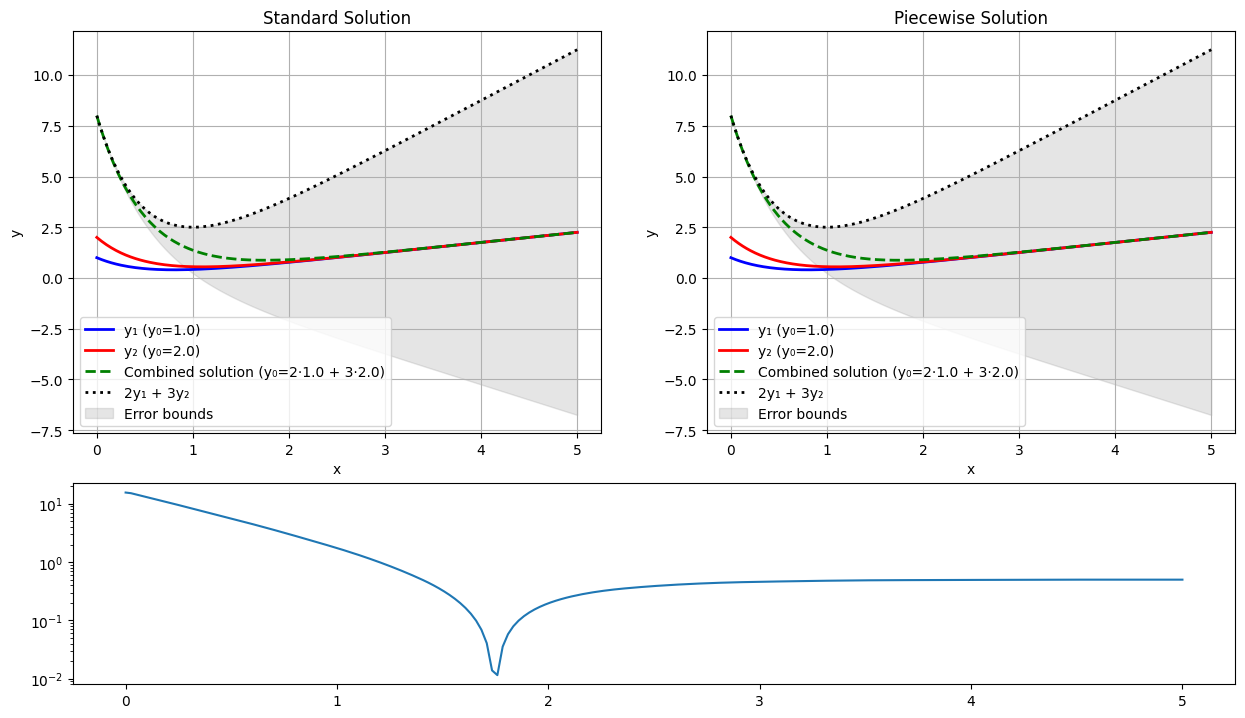

In [5]:
"""
Enhanced Linear Equations Analysis with Piecewise Solution
=====================================================

Abstract:
This script implements a piecewise solution strategy for the linear differential
equation, breaking the domain into smaller intervals to improve accuracy.
Includes stability analysis to identify critical regions and error sources.

Key Features:
- Piecewise solution with continuity enforcement
- Local and global stability analysis
- Error propagation visualization
- Comparative analysis with previous methods
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib.gridspec import GridSpec

def linear_de(x, y, k=2):
    """Define linear DE: dy/dx + 2y = x"""
    return x - k*y

def solve_piecewise(y0, x_start, x_end, n_pieces=5, method='RK45'):
    """
    Solve DE using piecewise approach

    Parameters:
        y0: Initial condition
        x_start, x_end: Domain bounds
        n_pieces: Number of subintervals
        method: Numerical method to use
    """
    x_splits = np.linspace(x_start, x_end, n_pieces + 1)
    x_detailed = []
    y_detailed = []
    local_errors = []

    current_y0 = y0

    for i in range(n_pieces):
        x_local = np.linspace(x_splits[i], x_splits[i+1], 50)

        solution = solve_ivp(
            linear_de,
            (x_splits[i], x_splits[i+1]),
            [current_y0],
            t_eval=x_local,
            method=method,
            rtol=1e-10,
            atol=1e-12
        )

        # Calculate local stability metric
        local_stability = np.gradient(solution.y[0], x_local)
        local_errors.append(np.max(np.abs(local_stability)))

        x_detailed.extend(x_local)
        y_detailed.extend(solution.y[0])

        # Update initial condition for next piece
        current_y0 = solution.y[0][-1]

    return np.array(x_detailed), np.array(y_detailed), np.array(local_errors)

# Set up domain and constants
x_range = (0, 5)
a, b = 2, 3
n_intervals = 10  # Number of piecewise intervals

# Generate solutions
solutions = {}
methods = ['Standard', 'Piecewise']

for method in methods:
    if method == 'Standard':
        # Standard solution (for comparison)
        x = np.linspace(*x_range, 200)
        y1 = solve_ivp(linear_de, x_range, [1.0], t_eval=x).y[0]
        y2 = solve_ivp(linear_de, x_range, [2.0], t_eval=x).y[0]
        y_combined = solve_ivp(linear_de, x_range, [a*1.0 + b*2.0], t_eval=x).y[0]
        y_superposition = a*y1 + b*y2
        local_errors = np.gradient(y_combined, x)

    else:
        # Piecewise solution
        x, y1, errs1 = solve_piecewise(1.0, *x_range, n_intervals)
        _, y2, errs2 = solve_piecewise(2.0, *x_range, n_intervals)
        _, y_combined, errs_combined = solve_piecewise(a*1.0 + b*2.0, *x_range, n_intervals)
        y_superposition = a*y1 + b*y2
        local_errors = errs_combined

    abs_error = np.abs(y_combined - y_superposition)
    rel_error = abs_error / np.abs(y_combined) * 100

    solutions[method] = {
        'x': x,
        'y1': y1,
        'y2': y2,
        'combined': y_combined,
        'superposition': y_superposition,
        'abs_error': abs_error,
        'rel_error': rel_error,
        'local_errors': local_errors
    }

# Create visualization
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(4, 2, height_ratios=[2, 1, 1, 1])

# Plot solutions
for idx, method in enumerate(methods):
    ax = fig.add_subplot(gs[0, idx])
    sol = solutions[method]

    ax.plot(sol['x'], sol['y1'], 'b-', label='y₁ (y₀=1.0)', linewidth=2)
    ax.plot(sol['x'], sol['y2'], 'r-', label='y₂ (y₀=2.0)', linewidth=2)
    ax.plot(sol['x'], sol['combined'], 'g--',
           label=f'Combined solution (y₀={a}·1.0 + {b}·2.0)', linewidth=2)
    ax.plot(sol['x'], sol['superposition'], 'k:',
           label=f'{a}y₁ + {b}y₂', linewidth=2)

    ax.fill_between(sol['x'],
                   sol['combined'] - sol['abs_error'],
                   sol['combined'] + sol['abs_error'],
                   color='gray', alpha=0.2, label='Error bounds')

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{method} Solution')
    ax.legend()

# Plot stability analysis
ax_stab = fig.add_subplot(gs[1, :])
for method in methods:
    ax_stab.semilogy(solutions[method]['x'],
                    np.abs(solutions[method]['local_errors']),
                    label=f'{method} Local Stability')
ax_stab.grid(True)
ax_stab.set_xlabel('x')
ax_stab.set_ylabel('Local Stability (log scale)')
ax_stab.legend()
ax_stab.set_title('Stability Analysis')

# Plot absolute errors
ax_abs = fig.add_subplot(gs[2, :])
for method in methods:
    ax_abs.semilogy(solutions[method]['x'], solutions[method]['abs_error'],
                   label=f'{method} Absolute Error')
ax_abs.grid(True)
ax_abs.set_xlabel('x')
ax_abs.set_ylabel('Absolute Error (log scale)')
ax_abs.legend()

# Plot relative errors
ax_rel = fig.add_subplot(gs[3, :])
for method in methods:
    ax_rel.semilogy(solutions[method]['x'], solutions[method]['rel_error'],
                   label=f'{method} Relative Error (%)')
ax_rel.grid(True)
ax_rel.set_xlabel('x')
ax_rel.set_ylabel('Relative Error % (log scale)')
ax_rel.legend()

plt.tight_layout()

# Create comparative statistics table
verification_points = [0, 1, 2, 3, 4, 5]
stats_data = []

for x_val in verification_points:
    row = {'x': x_val}
    for method in methods:
        sol = solutions[method]
        idx = np.abs(sol['x'] - x_val).argmin()
        row.update({
            f'{method}_Abs_Error': sol['abs_error'][idx],
            f'{method}_Rel_Error(%)': sol['rel_error'][idx],
            f'{method}_Stability': np.abs(sol['local_errors'][idx])
        })
    stats_data.append(row)

stats_table = pd.DataFrame(stats_data)
stats_table = stats_table.round(8)

print("\nComparative Analysis at Verification Points:")
print("==========================================")
print(stats_table)

# Print summary statistics
print("\nSolution Stability Analysis:")
print("=========================")
for method in methods:
    sol = solutions[method]
    print(f"\n{method} Method:")
    print(f"Maximum Absolute Error: {sol['abs_error'].max():.2e}")
    print(f"Maximum Relative Error: {sol['rel_error'].max():.2e}%")
    print(f"Mean Stability Metric: {np.mean(np.abs(sol['local_errors'])):.2e}")
    print(f"Max Stability Metric: {np.max(np.abs(sol['local_errors'])):.2e}")

plt.show()